In [1]:
%matplotlib inline
from fastai.basics import *
from functools import reduce 

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
print(Config().data_path())
path = Config().data_path()/'mnist'

/home/ubuntu/.fastai/data


In [3]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

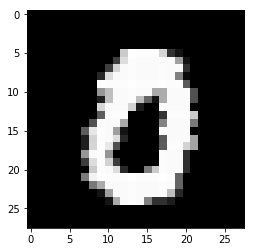

In [6]:
plt.imshow(x_train[69].reshape((28,28)), cmap="gray")
x_train.shape

In [7]:
x_train[0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32)

In [8]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [9]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [10]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [118]:
torch.addmm??

In [81]:
nn.Linear??

In [30]:
nn.functional.linear??

In [170]:
class SuperCoolLinearFunction(nn.Module):
    
    #Store dimensional information (Paramter Matrix, Activation Vector Size)
    def __init__(self, parametersDimension, activationsDimension, bias=True):
        super(SuperCoolLinearFunction, self).__init__()
        self.parametersDimesion = parametersDimension
        self.activationsDimension = activationsDimension
        self.parameterMatrix = nn.Parameter(torch.Tensor(activationsDimension, parametersDimension))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(activationsDimension))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.parameterMatrix, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.parameterMatrix)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    # Peform vector Matrix Multiplication
    def forward(self, inputVector):
        transposedParameterMatrix = self.parameterMatrix.t()
        if(inputVector.dim() == 2 and self.bias is not None):
            return torch.addmm(self.bias, inputVector, transposedParameterMatrix)
        else:
            outputVector = inputVector.matmul(transposedParameterMatrix)
            if self.bias is not None:
                outputVector += self.bias
            return outputVector

In [171]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.superCoolLinearFunction = SuperCoolLinearFunction(784, 10, bias=True)

    def forward(self, xb): return self.superCoolLinearFunction(xb)

In [199]:
model = Mnist_Logistic().cuda()

In [200]:
model

Mnist_Logistic(
  (superCoolLinearFunction): SuperCoolLinearFunction()
)

In [201]:
model.superCoolLinearFunction

SuperCoolLinearFunction()

In [202]:
model(x).shape

torch.Size([64, 10])

In [203]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [204]:
lr=2e-2

In [205]:
loss_func = nn.CrossEntropyLoss()

In [209]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = reduce(lambda acc, w: acc + w, map(lambda p: (p**2).sum(), model.parameters()), 0.)
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [207]:
losses = [update(x,y,lr) for x,y in data.train_dl]

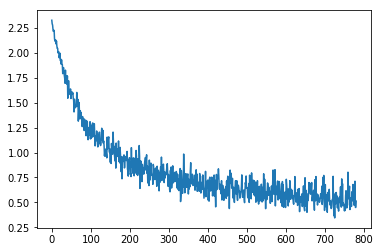

In [208]:
plt.plot(losses);

In [182]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = SuperCoolLinearFunction(784, 50, bias=True)
        self.lin2 = SuperCoolLinearFunction(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [183]:
model = Mnist_NN().cuda()

In [184]:
losses = [update(x,y,lr) for x,y in data.train_dl]

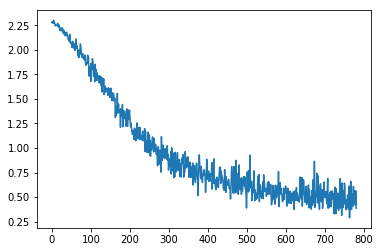

In [185]:
plt.plot(losses);

In [29]:
model = Mnist_NN().cuda()

In [30]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [31]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

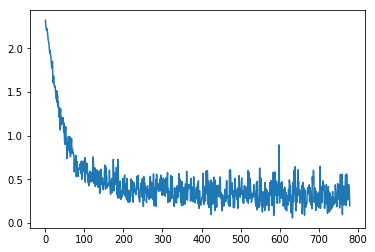

In [32]:
plt.plot(losses);

In [34]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /home/ubuntu/fastai/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


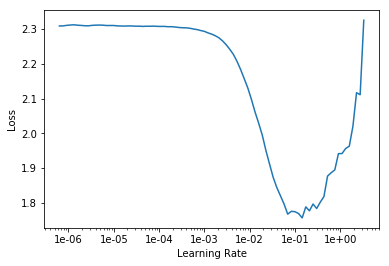

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.139161,0.127159,0.964300,00:06


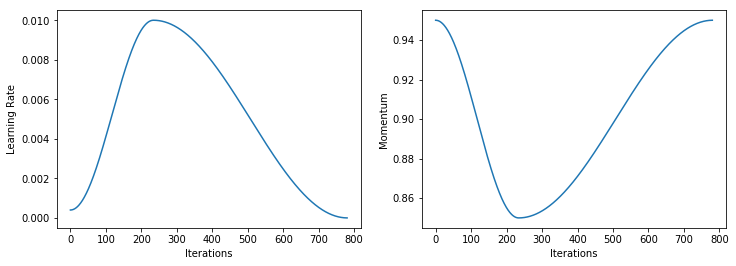

In [37]:
learn.recorder.plot_lr(show_moms=True)

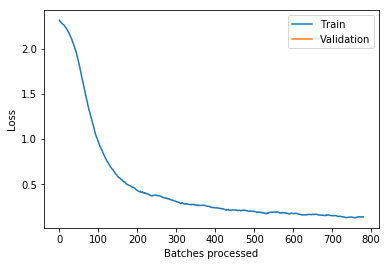

In [38]:
learn.recorder.plot_losses()

## fin